# Investment Analysis Project

- Assignee: Anna Benešová
- Date: 3.1.2025
- Subject: NMFP533

In [63]:
## Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import seaborn as sns
from tabulate import tabulate

In [55]:
# Additional instalations
#pip install seaborn
#pip install yfinance
#pip install tabulate

### Instructions

We were tasked with analyzing a set of NASDAQ stocks to construct a market portfolio across four main parts:

1. **Data Processing and Basic Exploration**  
2. **Efficient Frontier, Capital Market Line (CML), and Security Market Line (SML)**  
3. **Markowitz Model**  
4. **Out-of-Sample Investment with Initial Capital of \$100,000 USD**  

The assigned stocks are provided in the table below together with brief information about sector and S&P 500 status.  

| Ticker | Company             | Included in S&P 500 | Sector                 |  
| ------ | ------------------- | ------------------- | ---------------------- |  
| GOOGL  | Alphabet            | Yes                 | Communication Services |  
| AMGN   | Amgen               | Yes                 | Health Care            |  
| AVGO   | Broadcom            | Yes                 | Information Technology |  
| DLTR   | Dollar Tree         | Yes                 | Consumer Discretionary |  
| ISRG   | Intuitive Surgical  | Yes                 | Health Care            |  
| LULU   | Lululemon Athletica | Yes                 | Consumer Discretionary |  
| QCOM   | Qualcomm            | Yes                 | Information Technology |  
| TXN    | Texas Instruments   | Yes                 | Information Technology |  

# 1. Data Processing and Basic Exploration

In this section we will focus on data loading and necessary preprocessing as well as deploing basic exploration in form of plots and descriptive statistics

## 1.1 Data Processing

### 1.1.1 Data Loading

ng
For data acquisition, we utilized the *yfinance* library to retrieve historical stock prices spanning from January 1, 2021, to October 25, 2024. The data quality assessment revealed complete and consistent records with no anomalous values or irregularities. In accordance with the assignment requirements, we also obtained U.S. Treasury Bond data for the corresponding period, specifically selecting the one-month Treasury bill rate as our risk-free rate benchmauaffected stocks to be added]023-04-07

Daily returns $Y_j$ of stock j were calculated using the logarithm of the ratio between closing ($X^c_j$) and opening prices ($X^o_j$):

$$ Y_j = \log\left(\frac{X^c_j}{X^o_j} \right) $$



The logarithmic returns were chosen over simple returns for several key advantages:
1. They are additive over time, making them more suitable for time series analysis
2. They typically exhibit better statistical properties, including closer approximation to normal distribution
3. They prevent stock prices from becoming negative in theoretical models
4. They provide better handling of compounding effects

The annual risk-free rate ($r^{annual}_f$) was converted to a daily rate ($r_f$) using:

$$ r_f = \frac{\log(1 + \frac{r^{annual}_f}{100})}{252} $$

This logarithmic transformation is preferred over simple division by 252 trading days because it accounts for continuous compounding and maintains consistency with our logarithmic returns framework, ensuring more accurate risk-adjusted performance metrics.

### 1.1.2 Data Validation and Structure
We implemented two complementary data structures for our analysis:
1. An aggregated DataFrame of daily returns for all stocks, enabling efficient portfolio-level calculations and cross-sectional analysis
2. A dictionary with stock tickers as keys, facilitating individual stock analysis and maintaining data organization

During the validation process, we identified several dates where certain stocks had missing or inconsistent data. Using a custom validation function, we detected few dates with discrepancies. To maintain data integrity and prevent bias in our analysis, these dates were excluded from the dataset. The specific dates and affected stocks are detailed below:

In [64]:
def download_stock_data(stock_files, output_dir):
    """
    Download historical stock data using yfinance and save to CSV files with consistent date formatting.
    
    Parameters:
    stock_files (dict): Dictionary with stock tickers as keys and output filenames as values
    output_dir (str): Directory to save the CSV files
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Calculate date range (for the assignment period)
    start_date = '2021-01-01'  # January 1, 2021
    end_date = '2024-10-26'    # October 26, 2024
    
    # Download data for each ticker
    for ticker, filename in stock_files.items():
        try:
            # Get stock data
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date)
            
            # Convert index to date format without time component
            df.index = df.index.date
            
            # Name the index column
            df.index.name = 'Date'
            
            # Save to CSV
            output_path = os.path.join(output_dir, filename)
            df.to_csv(output_path)
            #print(f"Successfully downloaded data for {ticker} to {filename}")
            
        except Exception as e:
            print(f"Error downloading data for {ticker}: {str(e)}")
            
# When reading the CSV files back, use:
# df = pd.read_csv(file_path, parse_dates=True, index_col='Date')

In [65]:
# Define the directory containing your stock data
data_dir = r"C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data" #changable

# ABE tickers, all well defined
stock_files = {
    'GOOGL': 'Alphabet A Stock Price History.csv',
    'AMGN': 'Amgen Stock Price History.csv',
    'AVGO': 'Broadcom Stock Price History.csv',
    'DLTR': 'Dollar Tree Stock Price History.csv',
    'ISRG': 'Intuitive Surgical Stock Price History.csv',
    'LULU': 'Lululemon Athletica Stock Price History.csv',
    'QCOM': 'Qualcomm Stock Price History.csv',
    'TXN': 'Texas Instruments Stock Price History.csv',
}

# Dir for risk free asset
risk_free_file = r'C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\USYields2024.csv'

In [66]:
# Downloading data
stock_data = download_stock_data(stock_files,'stock_data')

In [67]:
# Function to calculate daily returns
def calculate_daily_returns(data):
    """
    Calculates daily returns as the logarithm of the ratio of Price to Open prices.
    """
    data['Daily_Return'] = np.log(data['Close'] / data['Open']) # log(Close/Open)
    return data[['Date', 'Daily_Return']]

In [68]:
# Load and process stock data

daily_returns = {} # Table with all daily returns in one place
all_data = {}  # Dictionary with ticker as key

for ticker, file_name in stock_files.items():
    file_path = os.path.join(data_dir, file_name)
    #print(f"Processing data for {ticker} from {file_path}...")
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data['Ticker'] = ticker  # Add a column for the ticker
    daily_returns[ticker] = calculate_daily_returns(data).set_index('Date')
    all_data[ticker] = data  # Store the full data in the dictionary

# Combine daily returns into a single DataFrame
combined_returns = pd.concat(
    [df['Daily_Return'].rename(ticker) for ticker, df in daily_returns.items()],
    axis=1
)

In [69]:
# Preprocessing of risk_free_file
risk_free_rate = pd.read_csv(risk_free_file)

# Remove leading/trailing spaces from column names
risk_free_rate.columns = risk_free_rate.columns.str.strip()

# Convert Date column to datetime format with dayfirst=True
risk_free_rate['Date'] = pd.to_datetime(risk_free_rate['Date'], dayfirst=True, errors='coerce')

# Ensure the '1 Mo' column is numeric and handle missing values
risk_free_rate['1 Mo'] = pd.to_numeric(risk_free_rate['1 Mo'], errors='coerce')

# Check if 'Date' column exists and proceed
if 'Date' in risk_free_rate.columns:
    # Filter columns
    risk_free_rate = risk_free_rate[['Date', '1 Mo']].dropna()

    # Filter date range
    mask = (risk_free_rate['Date'] >= '2021-01-01') & (risk_free_rate['Date'] <= '2024-10-25')
    risk_free_rate = risk_free_rate.loc[mask]

    # Convert the annualized rate into a daily rate (assuming 252 trading days in a year)
    #risk_free_rate['Daily_Risk_Free_Rate'] = (1 + risk_free_rate['1 Mo'] / 100) ** (1 / 252) - 1 #????
    risk_free_rate['Daily_Risk_Free_Rate'] = np.log(1 + risk_free_rate['1 Mo'] / 100)  / 252

    # Set the 'Date' column as the index for alignment with stock data
    risk_free_rate.set_index('Date', inplace=True)

    #print("\nRisk-Free Rate Data (Head):")
    #print(risk_free_rate.head())
    #print("\nRisk-Free Rate Data (Tail):")
    #print(risk_free_rate.tail())
    #print("\nDate range in the data:")
    #print(f"Start date: {risk_free_rate.index.min()}")
    #print(f"End date: {risk_free_rate.index.max()}")

    # Save the processed risk-free rate for later use
    risk_free_rate.to_csv('processed_risk_free_rate.csv')
    #print("Risk-free rate processing complete. File saved as 'processed_risk_free_rate.csv'.")
else:
    print("The 'Date' column is missing or misnamed.")
#TODO hide

In [70]:
def compare_and_clean_dates(combined_returns, risk_free_rate):
    """
    Compare and clean dates between two dataframes, removing time components
    and handling timezone differences.
    
    Parameters:
    combined_returns (pd.DataFrame): DataFrame with potential timezone-aware dates
    risk_free_rate (pd.DataFrame): DataFrame with datetime index
    
    Returns:
    tuple: (missing_dates, cleaned_combined_returns, cleaned_risk_free_rate)
    """
    # Convert combined returns dates - handle timezone aware dates
    combined_dates = combined_returns.index.tz_localize(None)  # Remove timezone first
    combined_dates = pd.to_datetime(combined_dates).date  # Then convert to date
    
    # Convert risk free dates
    risk_free_dates = pd.to_datetime(risk_free_rate.index).date
    
    # Find missing dates
    combined_dates_set = set(combined_dates)
    risk_free_dates_set = set(risk_free_dates)
    missing_dates = sorted(combined_dates_set - risk_free_dates_set)
    missing_dates2 = sorted(risk_free_dates_set- combined_dates_set )
    
    # Create new DataFrames with clean dates
    cleaned_combined_returns = combined_returns.copy()
    cleaned_combined_returns.index = combined_dates
    
    cleaned_risk_free_rate = risk_free_rate.copy()
    cleaned_risk_free_rate.index = risk_free_dates
    
    return missing_dates, missing_dates2, cleaned_combined_returns, cleaned_risk_free_rate



In [71]:
# Usage example:
missing_dates, missing_dates2, clean_returns, clean_risk_free = compare_and_clean_dates(combined_returns, risk_free_rate)
# Cleaning combined
#combined_returns_cleaned = combined_returns[~combined_returns.index.isin(missing_dates)]
# Print missing dates
print("Missing Dates in Risk-Free Rate Data:")
for date in missing_dates:
    print(date)
print("Missing Dates in Combo Rate Data:")
for date in missing_dates2:
    print(date)

# Print sample of cleaned dates
print("\nSample of Cleaned Combined Returns Dates:")
print(clean_returns.index[:5])
print("\nSample of Cleaned Risk-Free Dates:")
print(clean_risk_free.index[:5])

Missing Dates in Risk-Free Rate Data:
2021-10-11
2021-11-11
2022-10-10
2022-11-11
2023-10-09
2024-10-14
Missing Dates in Combo Rate Data:
2021-04-02
2023-04-07

Sample of Cleaned Combined Returns Dates:
Index([2021-01-04, 2021-01-05, 2021-01-06, 2021-01-07, 2021-01-08], dtype='object')

Sample of Cleaned Risk-Free Dates:
Index([2021-01-04, 2021-01-05, 2021-01-06, 2021-01-07, 2021-01-08], dtype='object')


In [72]:
# Ensure missing_dates are datetime64[ns]
missing_dates = pd.to_datetime(missing_dates)

# Now apply to combined_returns
combined_returns_cleaned = combined_returns[~combined_returns.index.isin(missing_dates)]

# Similarly for risk_free_rate
missing_dates2 = pd.to_datetime(missing_dates2)
risk_free_rate_cleaned = risk_free_rate[~risk_free_rate.index.isin(missing_dates2)]

## 1.2  Data Exploration

### 1.2.1 Desctiptive Statistics

First, we showcase an overview of common descriptive statistics of combined returns $Y$ and $r_f$. Notice all have the same count (954) indicating correct data loading and alignment across the assets.rations.rations.

The expected returns show the average daily returns for the assets. **GOOGL** ($\mu_{GOOGL}=0.00061$) and AVGO ($\mu_{AVGO}=0.00041$) exhibit positive expected returns, indicating slight daily growth, while other assets like **AMGN** ($\mu_{AMGN}=-0.00012$) and LULU ($\mu_{LULU}=-0.00067$) show negative expected returns, suggesting slight daily losses.

As for the covariance matrix, we can spot notable patterns include **GOOGL** having relatively high covariance with **AVGO** (0.00014), suggesting these tech stocks tend to move together. **ISRG** shows the highest variance ($\sigma_{ISRG}^2=0.00027$) among all assets, indicating greater price volatility.

Looking at the daily returns summary, we observe wide ranges in returns across assets. For instance, **ISRG** shows the highest maximum daily return (0.0799 or 7.99%) while **QCOM** experienced the lowest minimum return (-0.0783 or -7.83%). The risk-free rate averages around 2.96% annually (with a daily rate of 0.00011), providing context for evaluating excess returns.

The distribution of returns appears slightly asymmetric, as evidenced by the differences between mean ($\mu$) and median (50%) values across assets, suggesting potential skewness in daily returns that could be relevant for risk management considerations.

In [73]:
# Summary of Risk-Free Rate and combined Results
print("\nDaily Returns Summary:")
#print(combined_returns_cleaned.describe())
print(tabulate(combined_returns_cleaned.describe(), headers='keys', tablefmt='psql'))
print("\nRisk-Free Rate Summary:")
#print(risk_free_rate_cleaned.describe()
print(tabulate(risk_free_rate_cleaned.describe(), headers='keys', tablefmt='psql'))


Daily Returns Summary:
+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|       |         GOOGL |          AMGN |          AVGO |          DLTR |          ISRG |          LULU |          QCOM |           TXN |
|-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------|
| count | 954           | 954           | 954           | 954           | 954           | 954           | 954           | 954           |
| mean  |   0.000614421 |  -0.000123003 |   0.000411028 |  -1.88336e-05 |   6.55437e-05 |  -0.000671316 |  -0.000210069 |  -4.39508e-05 |
| std   |   0.0147859   |   0.0116044   |   0.019039    |   0.0171943   |   0.0165091   |   0.0187665   |   0.0188644   |   0.0142204   |
| min   |  -0.0535842   |  -0.0642703   |  -0.0842618   |  -0.135594    |  -0.0859937   |  -0.0826475   |  -0.078268    |  -0.0535006   |
| 25%   | 

In [27]:
#print("\n First 5 rows")
#print(combined_returns_cleaned.head())
#print("\n Last 5 rows")
#print(risk_free_rate_cleaned.tail())

In [74]:
# Exploratory analysis

#print("Performing exploratory analysis...")
mean_returns = combined_returns_cleaned.mean()
mean_returns_df = pd.DataFrame(mean_returns).reset_index()
mean_returns_df.columns = ['Ticker', 'Expected Returns']

cov_matrix = combined_returns_cleaned.cov()
auto_cov = combined_returns_cleaned.apply(lambda col: col.autocorr())
auto_cov_df = pd.DataFrame(mean_returns).reset_index()
auto_cov_df.columns = ['Ticker', 'Autocorrelations']


print("\nExpected Returns (Mean):")
print(tabulate(mean_returns_df, headers='keys', tablefmt='psql'))
print("\nCovariance Matrix:")
print(tabulate(cov_matrix,headers='keys', tablefmt='psql'))
print("\nAuto-covariances (Autocorrelations):")
print(tabulate(auto_cov_df,headers='keys', tablefmt='psql'))


Expected Returns (Mean):
+----+----------+--------------------+
|    | Ticker   |   Expected Returns |
|----+----------+--------------------|
|  0 | GOOGL    |        0.000614421 |
|  1 | AMGN     |       -0.000123003 |
|  2 | AVGO     |        0.000411028 |
|  3 | DLTR     |       -1.88336e-05 |
|  4 | ISRG     |        6.55437e-05 |
|  5 | LULU     |       -0.000671316 |
|  6 | QCOM     |       -0.000210069 |
|  7 | TXN      |       -4.39508e-05 |
+----+----------+--------------------+

Covariance Matrix:
+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       |       GOOGL |        AMGN |        AVGO |        DLTR |        ISRG |        LULU |        QCOM |         TXN |
|-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------|
| GOOGL | 0.000218624 | 2.98022e-05 | 0.000140792 | 4.83033e-05 | 0.000120249 | 0.000128083 | 0.000149259 | 0.000105315 

### 1.2.2 Visualization

Daily returns visualization reveals distinct volatility patterns across our stock portfolio. **GOOGL** exhibits clear heteroskedasticity with volatility clustering in 2022, accompanied by mild return autocorrelation during this turbulent period. In contrast, **AMGN** demonstrates more homoskedastic behavior, interrupted only by notable negative spikes in Q1 2024.

**AVGO** and **ISRG** share similar patterns but with different timing of volatile periods - **AVGO** showing increased volatility in 2024 with positive directional bias, while **ISRG** experienced heightened volatility in Q1 2022 during healthcare sector uncertainty (COVID). **DLTR** stands out with remarkably low baseline volatility, broken by extreme bidirectional spikes in Q3 2024.

**LULU** mirrors **ISRG's** pattern but with more pronounced negative spikes, while **QCOM** and **TXN** display relatively stable patterns with **QCOM** showing increased volatility in late 2024 and **TXN** exhibiting more pronounced movements early in the sample periosis.

These characteristics present challenges for **Markowitz optimization**, suggesting the need for rolling estimation windows, asymmetric risk measures, and tests for structural breaks in covariance estimation.
ation.covariance estimation period

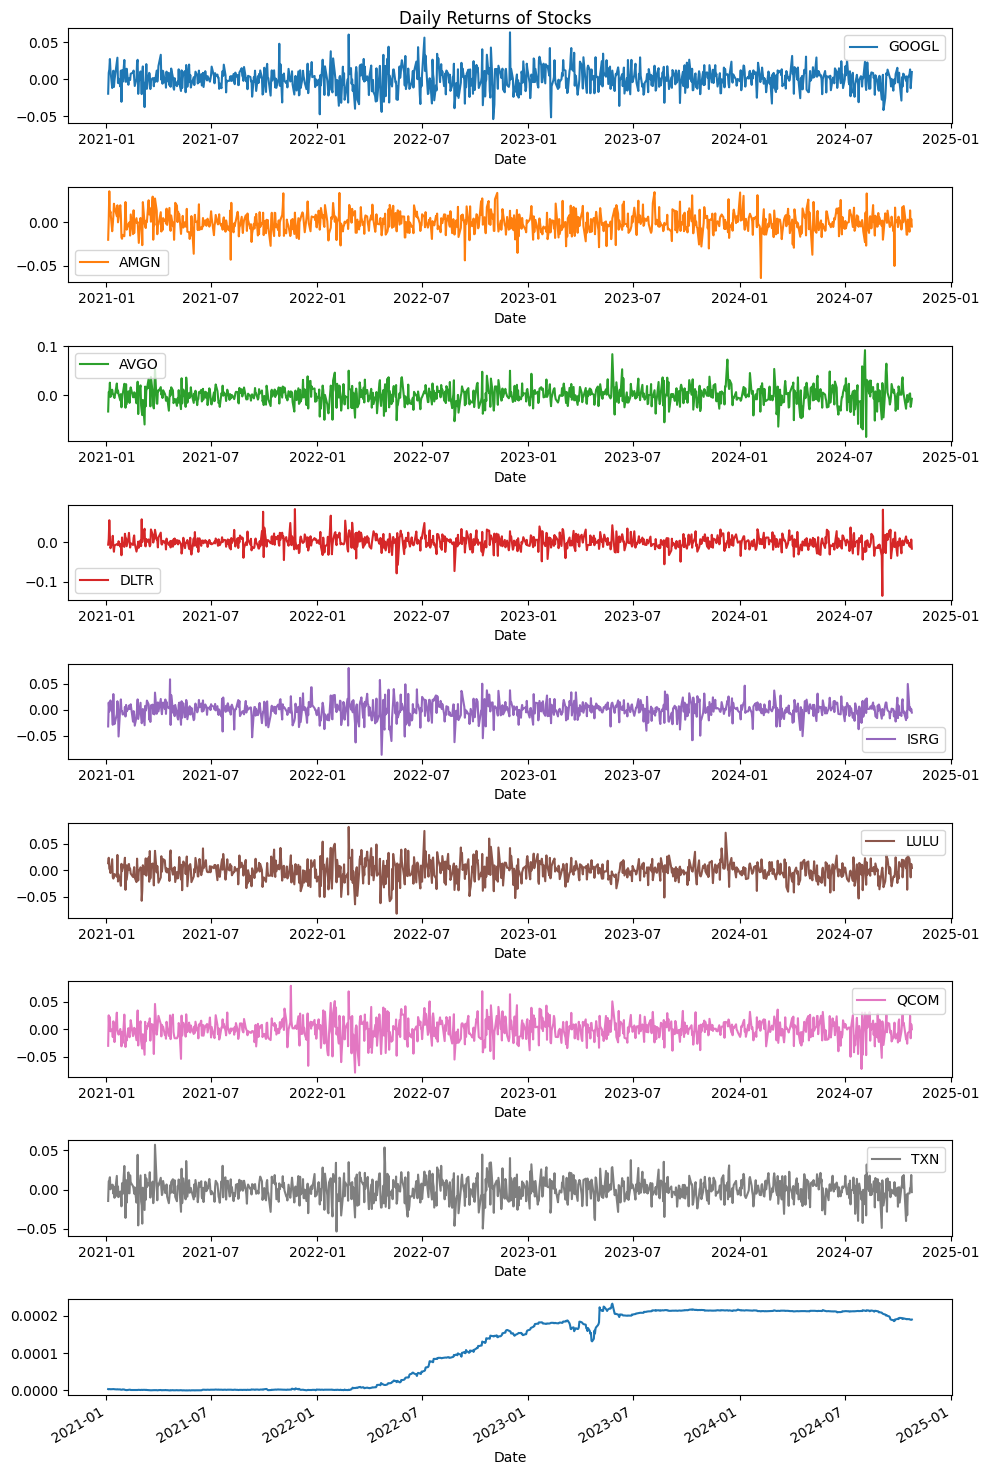

In [75]:
# Plotting daily returns
# Create a subplot for combined_returns_cleaned
fig, axes = plt.subplots(len(combined_returns_cleaned.columns) + 1, 1, figsize=(10, 15))

# Plot the daily returns of stocks
combined_returns_cleaned.plot(subplots=True, ax=axes[:len(combined_returns_cleaned.columns)], title='Daily Returns of Stocks')

# Plot the daily risk-free rate as the last subplot
risk_free_rate_cleaned['Daily_Risk_Free_Rate'].plot(ax=axes[len(combined_returns_cleaned.columns)])

# Adjust layout to make sure it looks nice
plt.tight_layout()

# Show the plot
plt.show()

In [42]:
#combined_returns.info()
#combined_returns.shape

In [77]:
def explore_data(stock_data):
    """
    Explore the downloaded stock data with various analyses.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    print("\n=== Data Exploration ===")
    
    # Define color palettes
    plot_color = '#1f77b4'  # Blue for the stock price plot
    return_color = '#ff7f0e'  # Orange for the daily return distribution plot
    
    for ticker, df in stock_data.items():
        print(f"\nAnalysis for {ticker}:")
        print("-" * 50)
        
        # Summary statistics with colorized output
        print("\nSummary Statistics:")
        print(tabulate(df.describe(), headers='keys', tablefmt='psql')) # Blue-colored table output
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\n\033[91mMissing Values:\033[0m")  # Red for missing values
            print(missing[missing > 0])
        
        # Calculate daily returns
        df['Daily_Return'] = np.log(df['Close']) - np.log(df['Open'])
        
        # Basic metrics
        print("\nKey Metrics:")
        print(f"Total Trading Days: {len(df)}")
        print(f"Average Daily Volume: {df['Volume'].mean():,.0f}")
        print(f"Average Daily Return: \033[92m{df['Daily_Return'].mean():.4%}\033[0m")  # Green for positive returns
        print(f"Return Volatility: {df['Daily_Return'].std():.4%}")
        print(f"Maximum Daily Gain: \033[92m{df['Daily_Return'].max():.4%}\033[0m")  # Green for gains
        print(f"Maximum Daily Loss: \033[91m{df['Daily_Return'].min():.4%}\033[0m")  # Red for losses
        
        # Plot price history with a custom color
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'], color=plot_color)
        plt.title(f'{ticker} Stock Price History', color=plot_color)
        plt.xlabel('Date', color=plot_color)
        plt.ylabel('Price', color=plot_color)
        plt.grid(True)
        plt.xticks(color=plot_color)
        plt.yticks(color=plot_color)
        plt.show()
        
        # Plot daily returns distribution with a custom color
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Daily_Return'], kde=True, color=return_color)
        plt.title(f'{ticker} Daily Returns Distribution', color=return_color)
        plt.xlabel('Daily Return', color=return_color)
        plt.ylabel('Frequency', color=return_color)
        plt.xticks(color=return_color)
        plt.yticks(color=return_color)
        plt.show()

In [48]:
#all_data['GOOGL'] #all data in one frame (disctionary)
#combined_returns #This one is more important

In the following script, we used the dictionary dataframe to iteratively explore each stock. The summary statistics include following metrics:

- `Open`: Day's first trade price
- `Close`: Final trading price
- `High/Low`: Price extremes during session
- `Volume`: Number of shares traded
- `Dividends`: Cash distributions to shareholders
- `Stock Splits`: Share quantity adjustments
- `Daily Returns`: Log returnssurge on automotive chip demandficant upward movementisk management strategies.

Distribution analysis reveals some leptokurtic tendencies across all stocks, with **DLTR** exhibiting the highest kurtosis.


Trading volumes showcase significant disparities:
- **GOOGL**: Highest volume (25x peers omitting **AVGO**) 
- **AVGO**: Second most traded, boosted by semiconductor sector focus
- **ISRG**/**LULU**: Lowest volumes suggesting liquidity constraints

Maximum daily gains were led by **ISRG** (7.99% - possible surgical robot market expansion) while largest losses were seen in **DLTR** (-13.55% - Q4 2024 earnings miss, inflation impact), showcasing the range of price movements in our portfolio.

Daily returns distributions:
- **GOOGL**: Normal distributed
- **AMGN**: Slightly heavier right tail
- **DLTR** and **ISRG**: Heaviest left tails indicating large loss events
- **DLTR**: Shows leptokurtic pattern (higher, sharper peak) suggesting frequent small moves with occasional extreme events

Price history analysis:
- **GOOGL**: Two local maxima, reflecting tech sector trends
- **AMGN**: More volatile pattern with strong upward momentum in 2024
- **AVGO**: Lower volatility historically with steep rise and two significant negative spikes in Q4 2024
- **DLTR**: Shows concerning downward trend in Q4 2024, dropping >30% from peak
- **ISRG**: Similar pattern to **AVGO** with notable dip around day 400
- **QCOM**: Exhibits cyclical pattern with sharp spike in Q3 2024 followed by correction
- **TXN**: Most stable until Q3 2024 when it showed significant upward movement (possibly surge on automotive chip demand) 


=== Data Exploration ===

Analysis for GOOGL:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+---------------+---------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |        Volume |     Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+---------------+---------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      | 960           | 960           |    960         |   960          |
| mean  | 2022-11-29 13:08:59.999999744 | 127.637  | 129.078  | 126.289  | 127.702  |   3.14093e+07 |   0.000416667 |      0.0208333 |     0.00062885 |
| min   | 2021-01-04 00:00:00           |  84.7059 |  86.2075 |  83.039  |  83.1287 |   9.7014e+06  |   0           |    

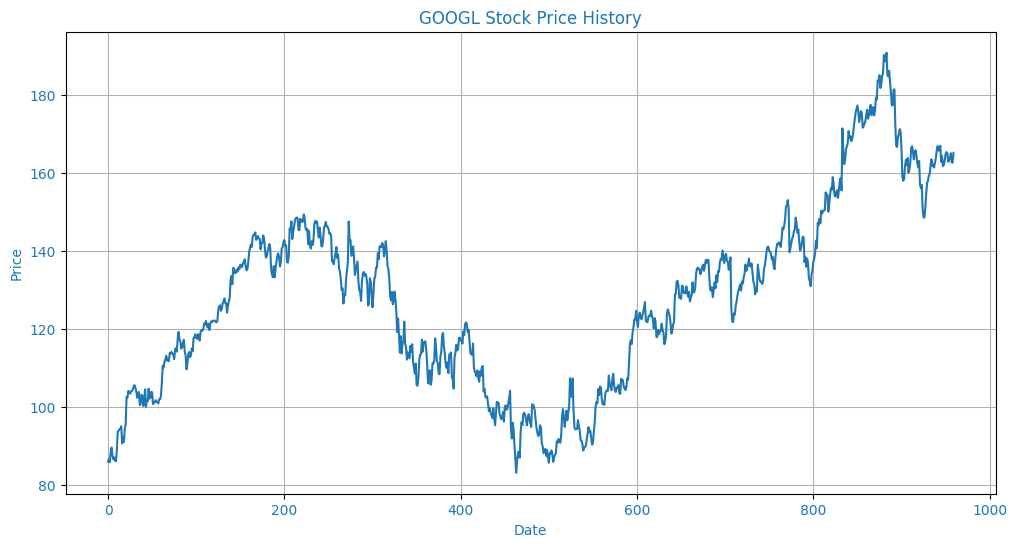

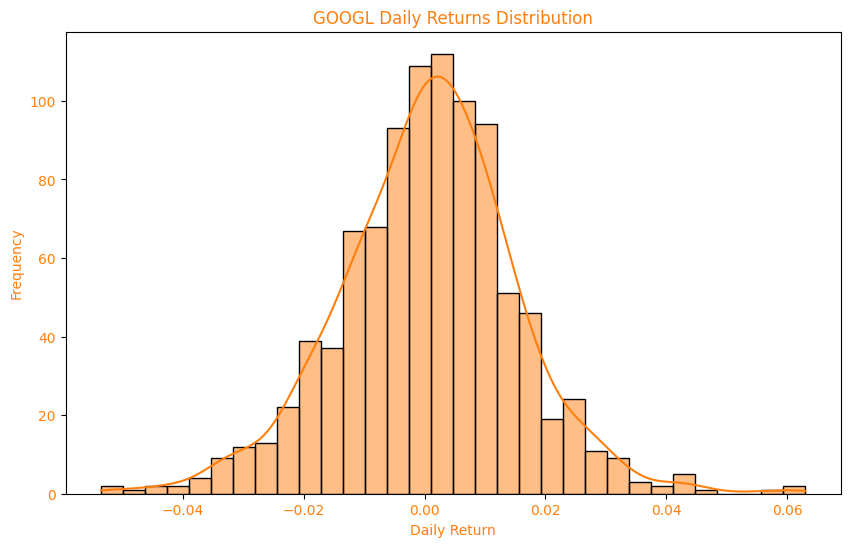


Analysis for AMGN:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      |    960           | 960         |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 242.97   | 245.214  | 240.588  | 242.931  |      2.6413e+06  |   0.0313229 |              0 |   -0.000155592 |
| min   | 2021-01-04 00:00:00           | 183.744  | 186.182  | 182.094  | 182.314  | 930800           |   0         |              0 |   -0.06

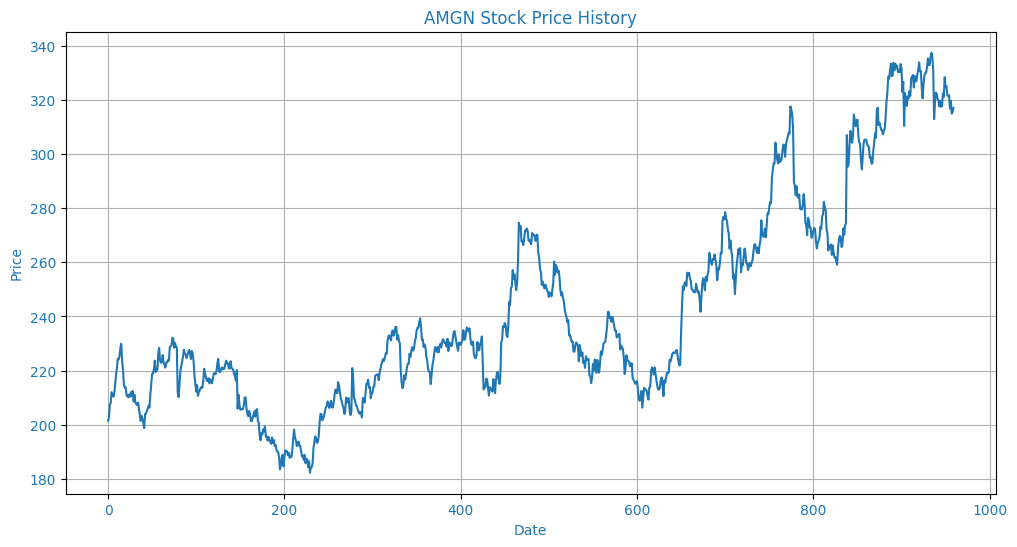

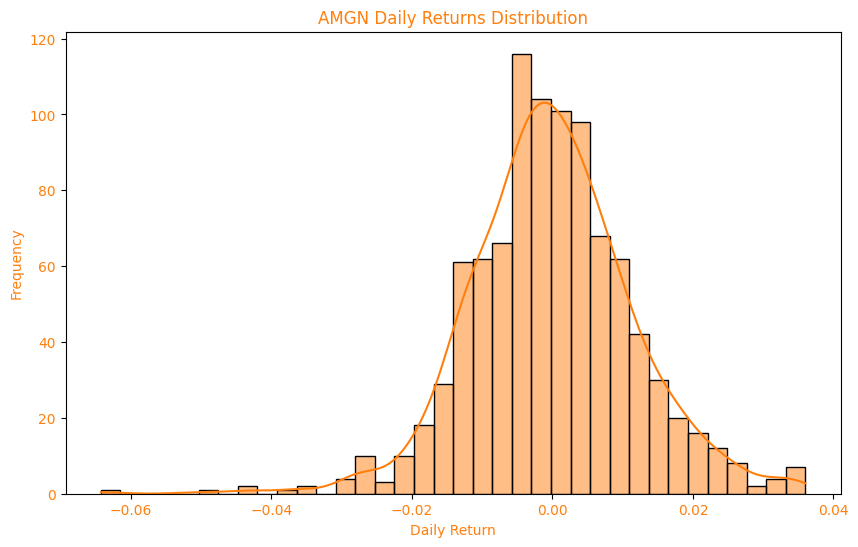


Analysis for AVGO:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+---------------+--------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |        Volume |    Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+---------------+--------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      | 960           | 960          |    960         |  960           |
| mean  | 2022-11-29 13:08:59.999999744 |  76.2162 |  77.2969 |  75.1017 |  76.2381 |   2.46384e+07 |   0.00694271 |      0.0104167 |    0.000404487 |
| min   | 2021-01-04 00:00:00           |  38.4245 |  38.9773 |  38.0578 |  38.2384 |   5.952e+06   |   0          |      0         |   -0.0842618   |
| 

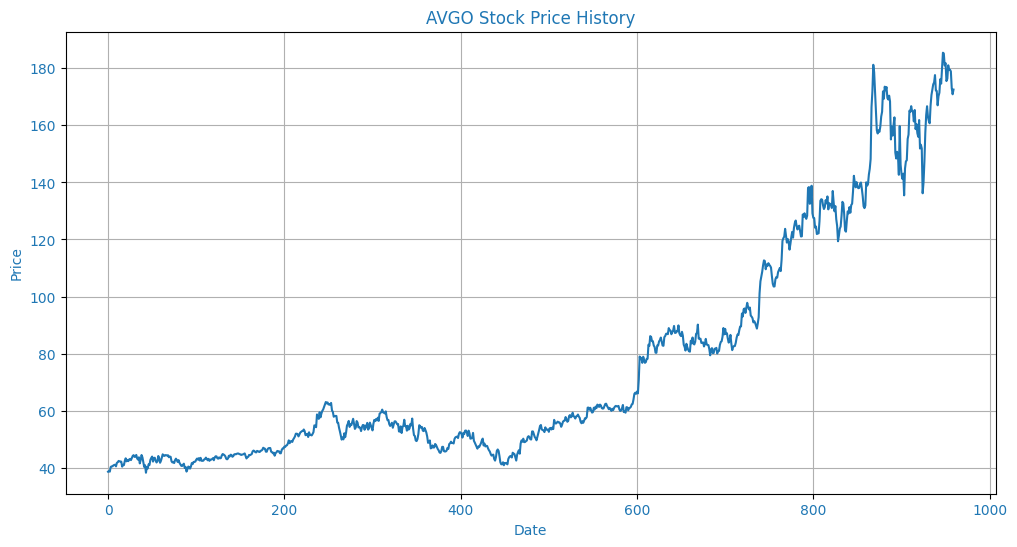

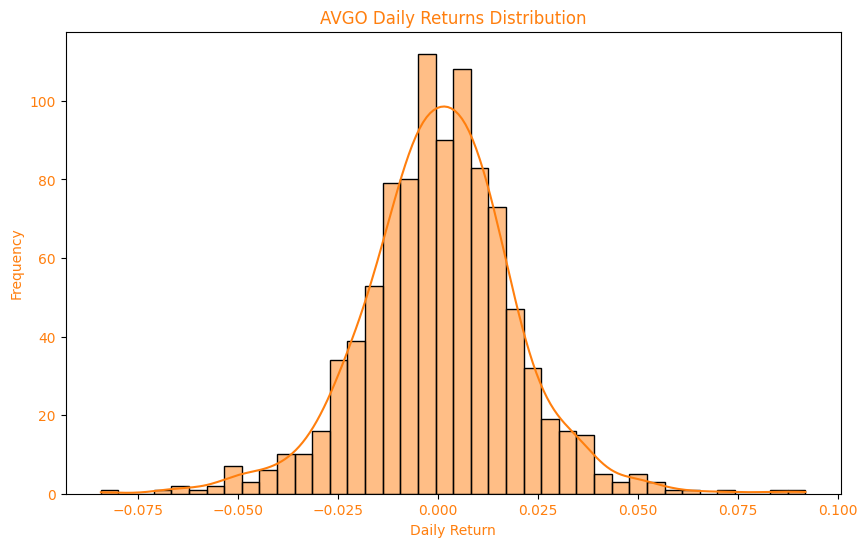


Analysis for DLTR:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      |    960           |         960 |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 127.314  | 128.909  | 125.737  | 127.338  |      2.65929e+06 |           0 |              0 |   -2.71592e-05 |
| min   | 2021-01-04 00:00:00           |  63.09   |  66.99   |  60.82   |  63.56   | 685700           |           0 |              0 |   -0.13

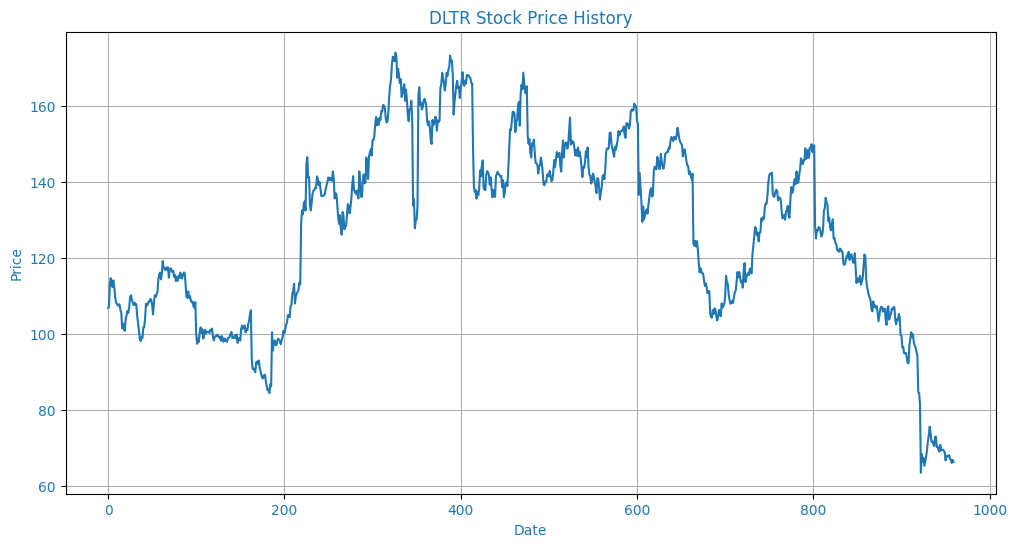

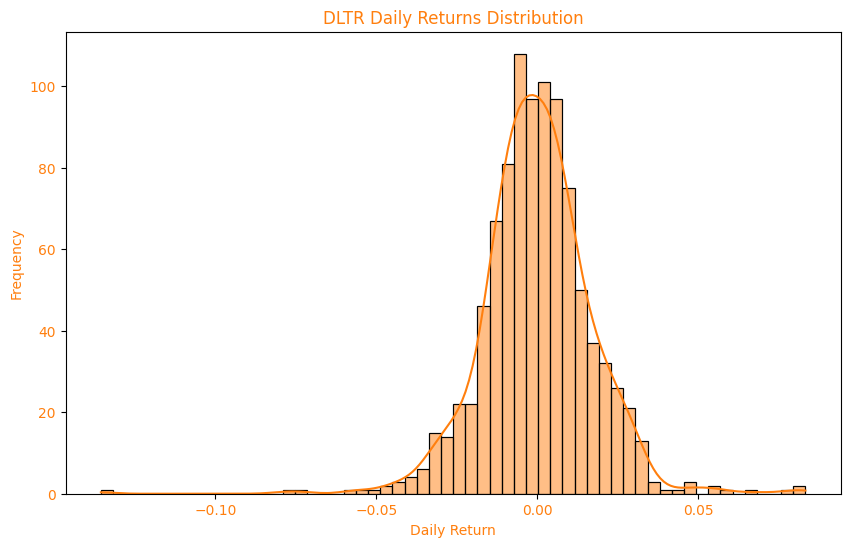


Analysis for ISRG:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+---------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |   Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+---------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960     |    960           |         960 |    960         |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 310.475  | 314.038  | 306.676  | 310.495 |      1.74481e+06 |           0 |      0.003125  |    6.63819e-05 |
| min   | 2021-01-04 00:00:00           | 181.11   | 186.97   | 180.07   | 183.06  | 601300           |           0 |      0         |   -0.0859937 

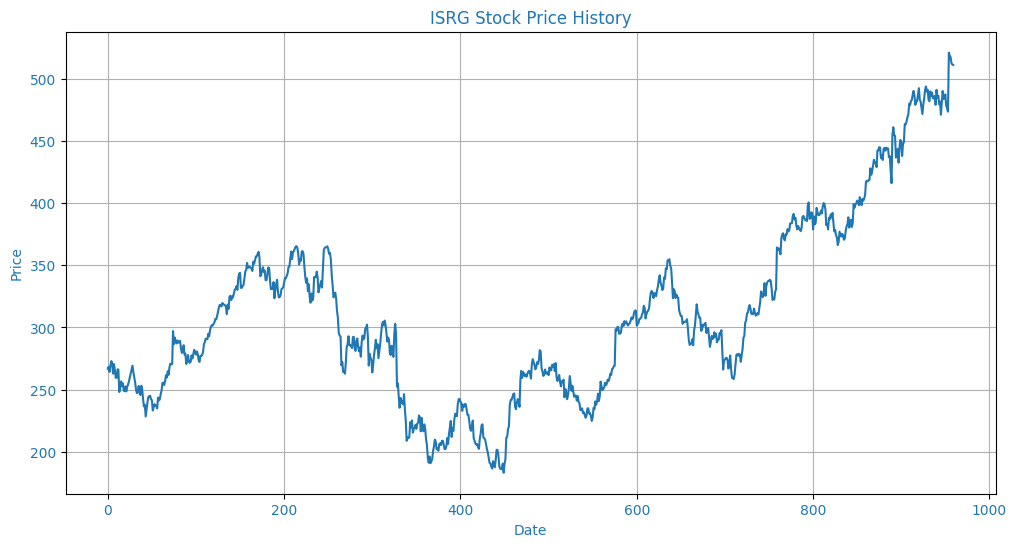

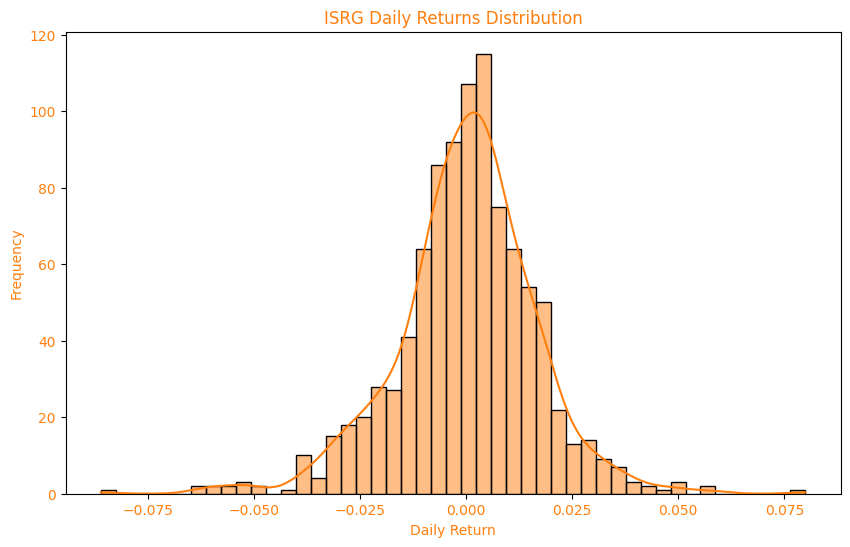


Analysis for LULU:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      |    960           |         960 |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 353.972  | 358.551  | 348.914  | 353.735  |      1.61078e+06 |           0 |              0 |   -0.000684617 |
| min   | 2021-01-04 00:00:00           | 228.08   | 236.35   | 226.01   | 233.4    | 397400           |           0 |              0 |   -0.08

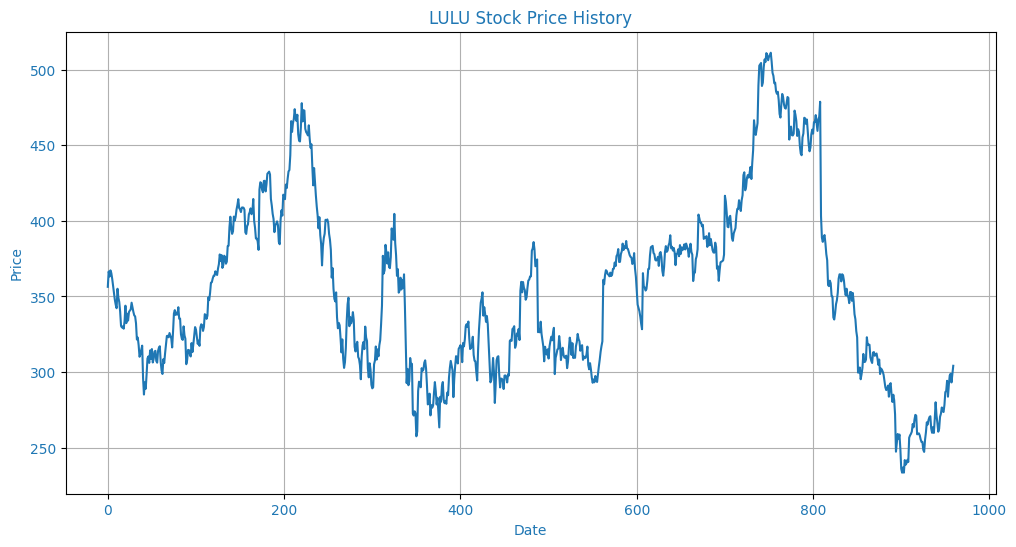

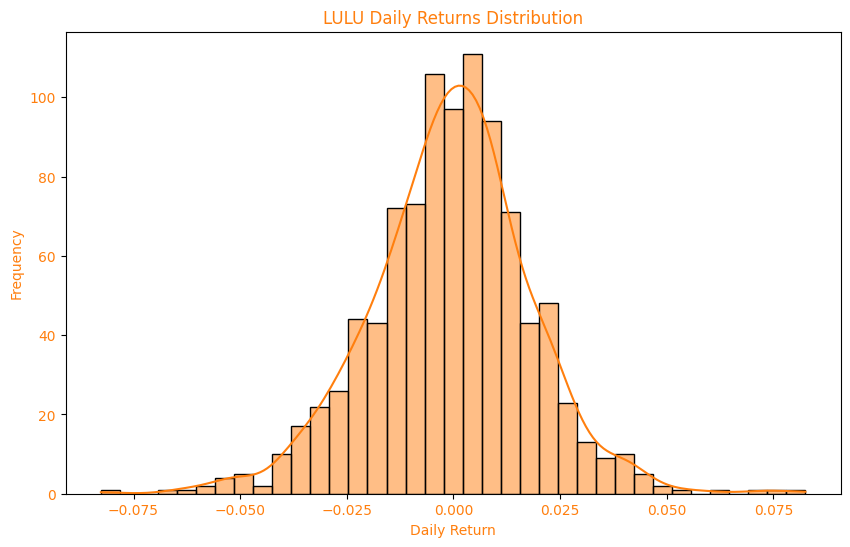


Analysis for QCOM:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+---------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |        Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+---------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      | 960           | 960         |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 136.804  | 138.676  | 134.8    | 136.768  |   8.93573e+06 |   0.0117396 |              0 |   -0.000179409 |
| min   | 2021-01-04 00:00:00           |  97.9485 |  99.1113 |  96.737  |  98.5877 |   2.662e+06   |   0         |              0 |   -0.078268    |
| 25%   

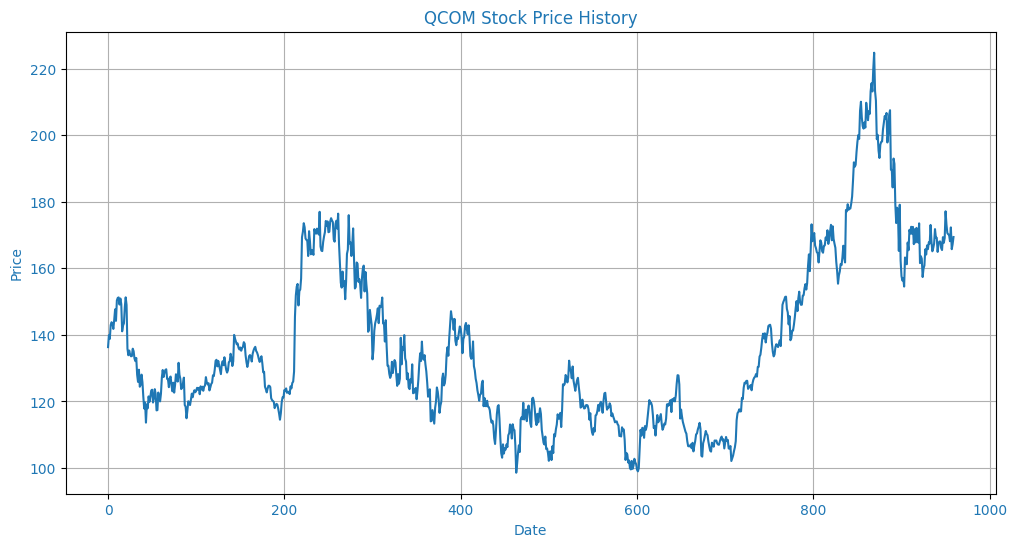

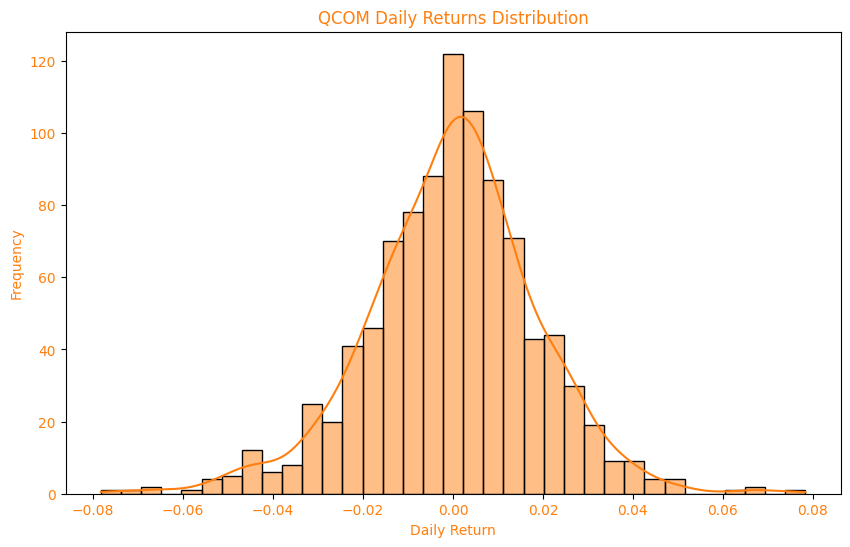


Analysis for TXN:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+---------+----------+----------+---------------+-------------+----------------+----------------+
|       | Date                          |     Open |    High |      Low |    Close |        Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+---------+----------+----------+---------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960     | 960      | 960      | 960           | 960         |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 167.156  | 168.889 | 165.267  | 167.147  |   5.18338e+06 |   0.0185625 |              0 |   -2.55494e-05 |
| min   | 2021-01-04 00:00:00           | 135.403  | 137.493 | 134.223  | 136.608  |   1.5864e+06  |   0         |              0 |   -0.0535006   |
| 25%   | 2021-

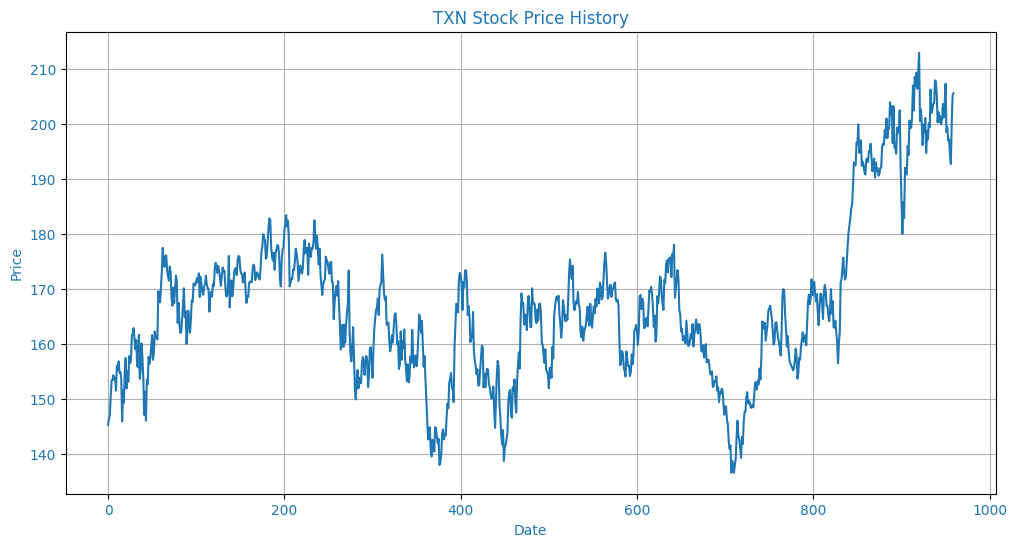

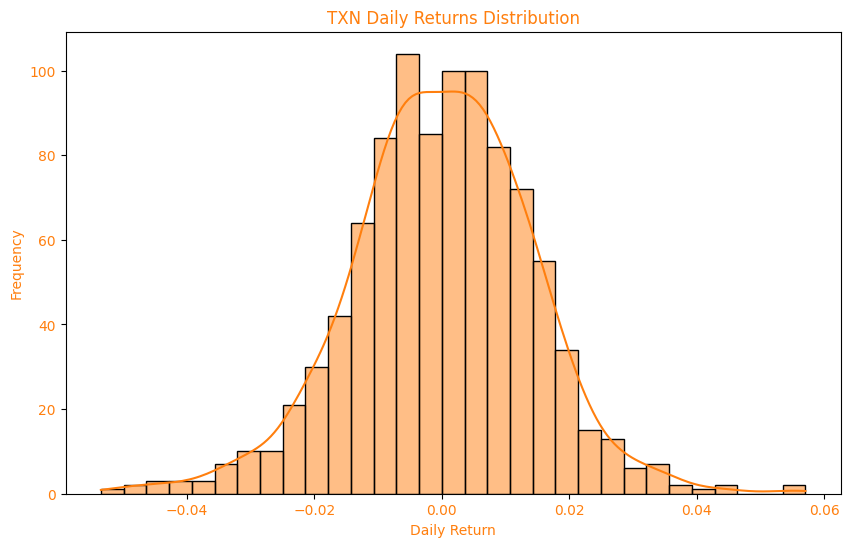

In [78]:
explore_data(all_data)

In [79]:
def plot_stock_data_comparisons(stock_data):
    """
    Plot multiple aspects of stock data for all tickers in the dictionary.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

    # Plot Open Prices
    for ticker, df in stock_data.items():
        axes[0].plot(df.index, df['Open'], label=ticker)
    axes[0].set_title('Open Prices for All Stocks', fontsize=14)
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True)
    
    # Plot Volumes
    for ticker, df in stock_data.items():
        axes[1].plot(df.index, df['Volume'], label=ticker)
    axes[1].set_title('Volumes for All Stocks', fontsize=14)
    axes[1].set_ylabel('Volume')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True)

    # Plot Low-High Range (Confidence Interval)
    for ticker, df in stock_data.items():
        axes[2].fill_between(df.index, df['Low'], df['High'], alpha=0.3, label=ticker)
    axes[2].set_title('Low-High Range for All Stocks', fontsize=14)
    axes[2].set_ylabel('Price Range')
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid(True)

    # Plot Dividends
    for ticker, df in stock_data.items():
        axes[3].plot(df.index, df['Dividends'], label=ticker)
    axes[3].set_title('Dividends for All Stocks', fontsize=14)
    axes[3].set_ylabel('Dividends')
    axes[3].legend(loc='best', fontsize=10)
    axes[3].grid(True)

    # Plot Daily Returns
    for ticker, df in stock_data.items():
        axes[4].plot(df.index, df['Daily_Return'], label=ticker)
    axes[4].set_title('Daily Returns for All Stocks', fontsize=14)
    axes[4].set_ylabel('Daily Return')
    axes[4].legend(loc='best', fontsize=10)
    axes[4].grid(True)

    # Adjust layout and show plot
    plt.xlabel('Date', fontsize=12)
    plt.tight_layout()
    plt.show()


We also deployed script for combined plots that revelead some interesting notions.

In case of price movements in the first figure, **LULU** and **ISRG** show correlated movements until  Q2 2023, when **ISRG** broke away with stronger upward momentum, likely due to healthcare sector recovery. 
Furthemore, a group of four stocks (**GOOGL**, **AVGO**, **QCOM**, **TXN**) demonstrate similar price patterns, reflecting their shared exposure to tech sector dynamics. **DLTR** shows strongest negative correlation, 
particularly during retail sector stress perioAs for 

Moving on **LULU** experienced two notable downturns:
 1. Q1 2022, caused possibly by post-pandemic consumer behavior shift
 2. Q3-Q4 2022 probably happened because of  retail sector weakness and inventory challenges [Source](https://www.reuters.com/business/retail-consumer/lululemon-faces-sluggish-sales-upstart-brands-nip-its-heels-2024-12-04/?utm_source=chatgpt.com)

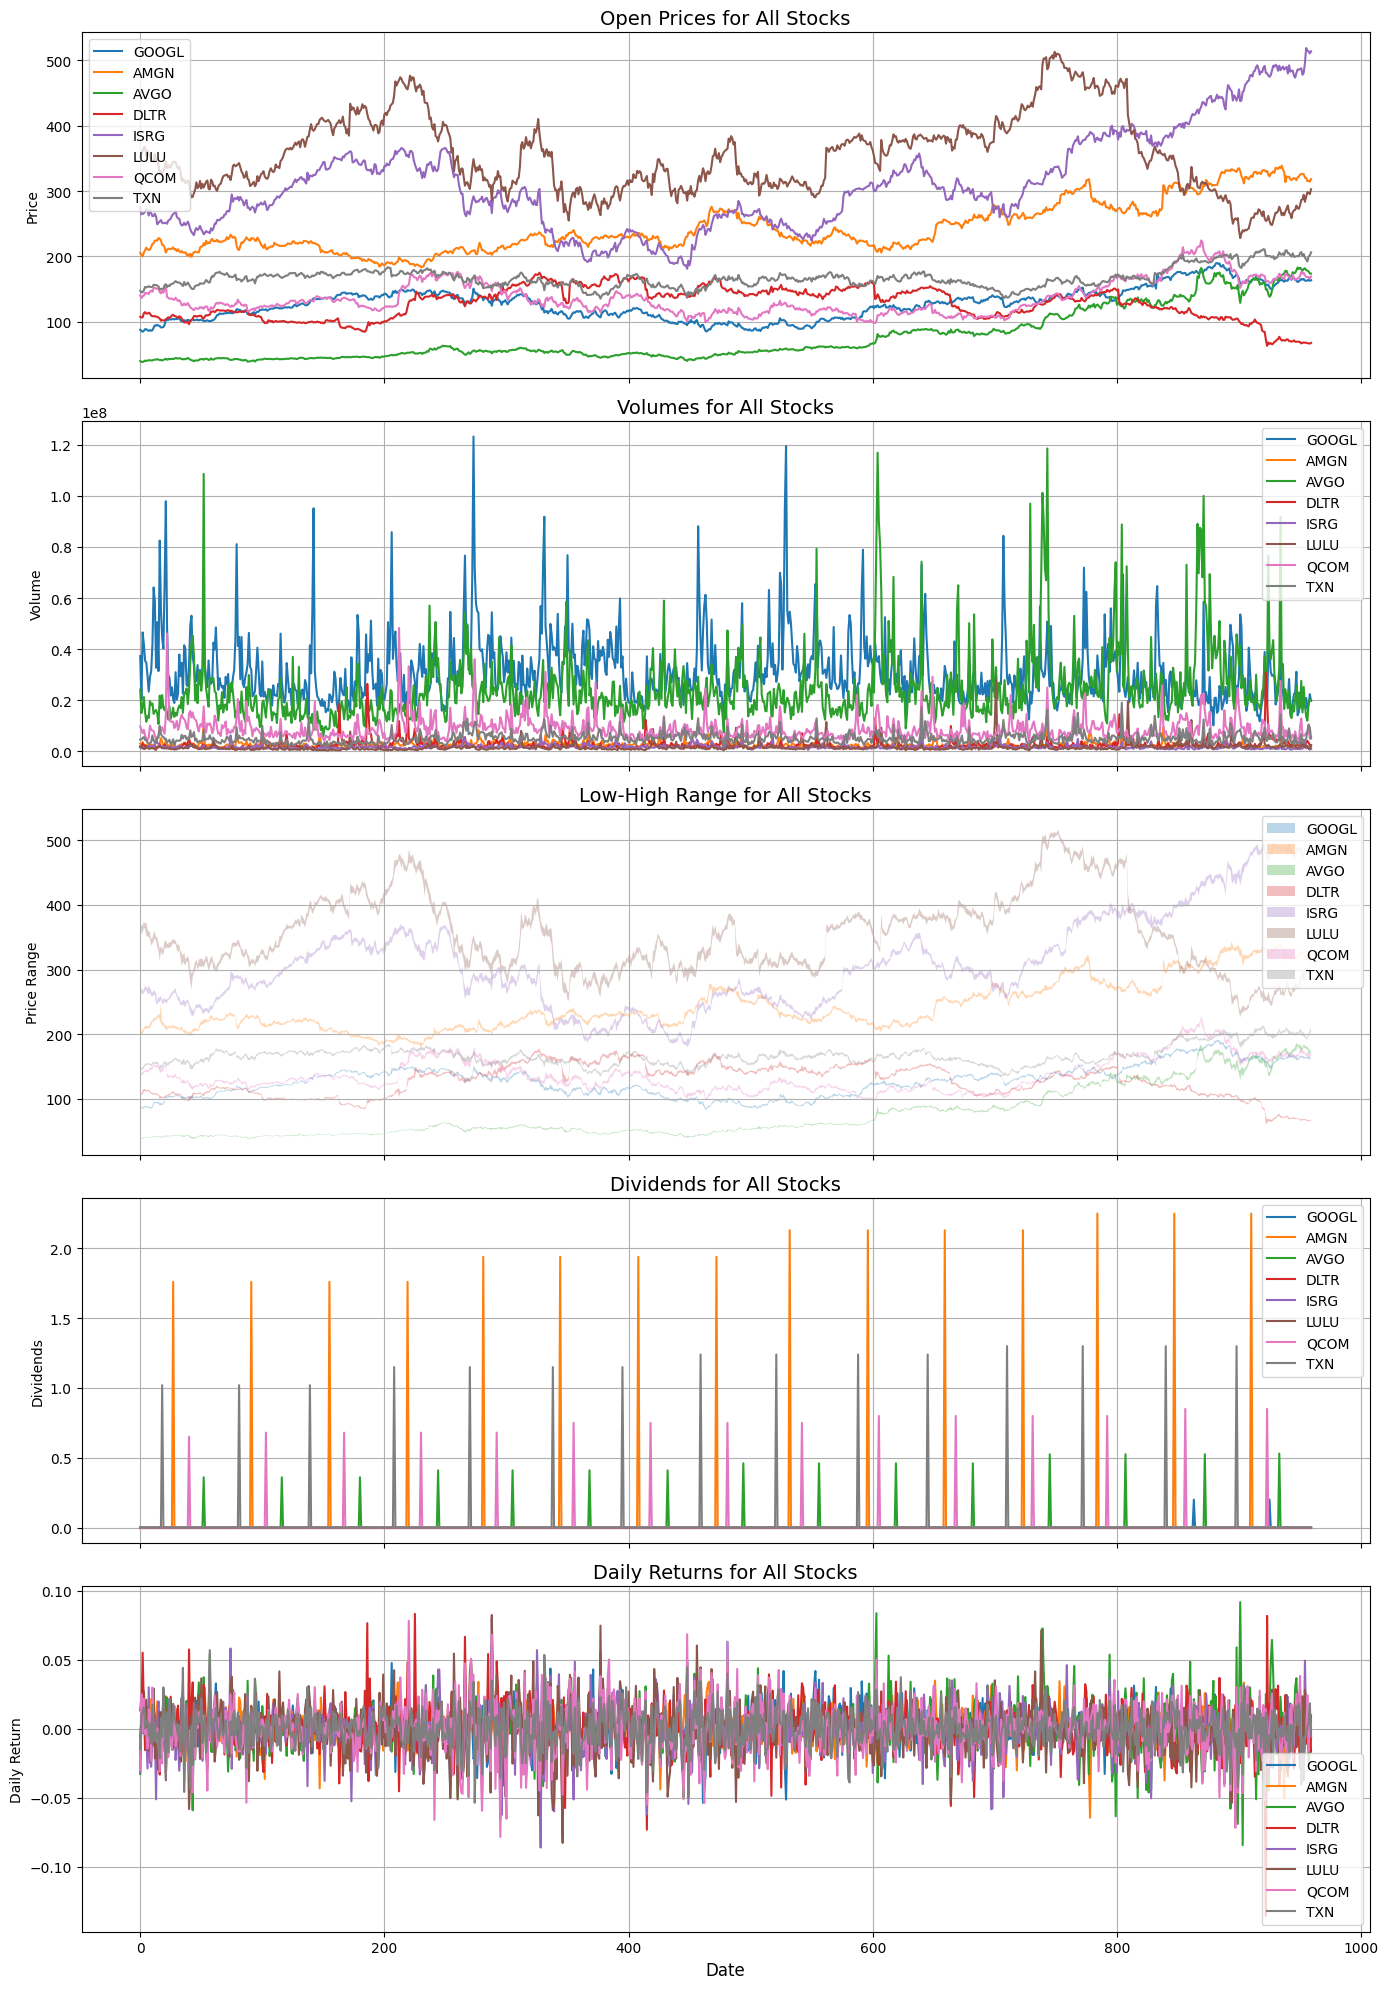

In [80]:
plot_stock_data_comparisons(all_data)

# 2. Efficient Portfolios Analysis

In this section, we analyze and estimate the set of efficient portfolios using historical data up to October 24, 2022 (end of business day). We will construct the efficient frontier without the risk-free rate ($r_f$), and subsequently calculate and plot both the Capital Market Line (CML) and Security Market Line (SML).

## 2.1. Efficient Frontier Estimation

We begin by computing the efficient frontier using our historical dataset. The process involves estimating two key parameters for each stock $i$:

- Expected returns ($\mu_i$)
- Variance-covariance matrix ($\Sigma$)

For portfolio calculations, we use the following formulas:

Portfolio expected return:
$$\mu_p = \sum_{i=1}^{n} w_i\mu_i \cdot \sqrt{252}$$
Portfolio standard deviation:
$$\sigma_p = \sqrt{w^T\Sigma w \cdot 252}$$

where:

- $w_i$ represents the weight of asset $i$
- $n$ is the number of trading days (252)
- $\sum_{i=1}^{n} w_i = 1$ (weight property)
- $w_i \geq 0$ (no short-selling constraint)

To visualize the possible portfolio set, we simulate 100,000 portfolios with randomly generated weights (normalized to sum to 1). The resulting scatter plot in the mean-std plane ($\mu$-$\sigma$) reveals a characteristic cloud of feasible portfolios. The upper boundary of this cloud forms the efficient frontier, representing portfolios that offer the highest expected return for a given level of risk.


Focusing on the plot, we can notice that the characteristic parabolic shape of the portfolio cloud is present and thus aligns with modern portfolio theory. Also approximately half of the simulated portfolios exhibit negative expected returns, which is consistent with our exploratory analysis findings. The efficient frontier should trace the south-west to west part of the cloud. 

In [81]:
combined_returns_cleaned.index = pd.to_datetime(combined_returns_cleaned.index)
risk_free_rate_cleaned.index = pd.to_datetime(risk_free_rate_cleaned.index)
start_date = '2021-01-01'
end_date = '2022-10-24'

# Filter the data by date range using the index
combined_returns_subset = combined_returns_cleaned[(combined_returns_cleaned.index >= start_date) & 
                                  (combined_returns_cleaned.index <= end_date)]
risk_free_subset = risk_free_rate_cleaned[(risk_free_rate_cleaned.index >= start_date) & 
                                  (risk_free_rate_cleaned.index <= end_date)]

In [93]:
#risk_free_subset

In [97]:
expected_returns = combined_returns_subset.mean()
covariance_matrix = combined_returns_subset.cov()
risk_free_rate_one = risk_free_subset['Daily_Risk_Free_Rate'].mean()

In [96]:
def portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual):
    """
    Calculate portfolio return and portfolio standard deviation.
    """
    # Annualized return
    portfolio_return = np.sum(weights * expected_returns) * timeAnnual 
    # Annualized standard deviation
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(timeAnnual)
    return portfolio_return, portfolio_stddev

#Correct, port returns, std

In [103]:
# Simulate random portfolios
num_portfolios = 100000
timeAnnual = 252  # Trading year
num_assets = len(expected_returns)
results = np.zeros((3, num_portfolios))  # Rows: return, risk (std dev), Sharpe ratio

In [104]:
# Simulate random portfolios
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets))
    weights /= np.sum(weights)
    portfolio_return, portfolio_stddev = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = (portfolio_return - risk_free_rate_one) / portfolio_stddev
    #print(results)

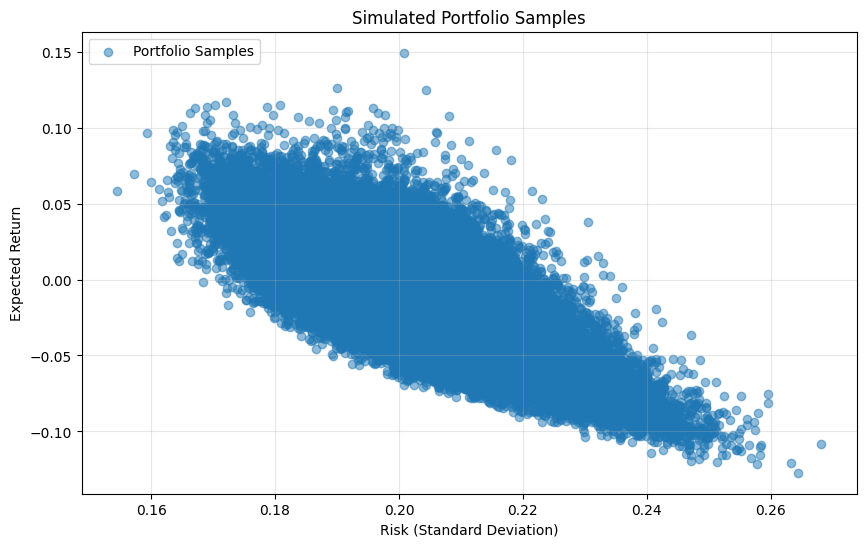

In [108]:

# Create the plot
plt.figure(figsize=(10, 6))

# Plot random portfolios
scatter = plt.scatter(results[1, :], results[0, :], 
                     alpha=0.5, 
                     label='Portfolio Samples')


plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Simulated Portfolio Samples')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()



## 2.2. Efficient Frontier and Capital Market Line


First, we subsettedting the risk-free r$r_f$ for given period andFd, we detdermine the minimum variance portfolio by minimizing the portfolio variance ($\sigma_p^2 = w^T\Sigma w$), subject tbasicmental constraints that portfolio weights must sum to one ($\sum_{i=1}^n w_i = 1$) and no short-selling is allowed ($w_i \geq 0$). This provides us with the lowest possible risk portfolio ispace of feasible choices. tangency.

For each portfolio along our frontier, we compute the Sharpe ratio ($sr = \frac{\mu_p - r_f}{\sigma_p}$), which measures the risk-adjusted excess return. This ratio serves as a key metric in identifying the optimal risk-return trade-off and helps us locate the tangency portfolio. The efficient frontier itself is constructed through an iterative optimization process, where we minimize portfolio risk for a series of target returns while maintaining our investment constraints.

The Capital Market Line (CML) emerges from this analysis, represented by the equation $\sigma_t (\mu_{CML} - r_f) =(\mu_t - r_f)\sigma_p$. Here $\mu_t$ and $\sigma_t$ correspond to the return and risk of the tangency portfolio, respectively. This portfolio, which maximizes the Sharpe ratio, represents the optimal risky portfolio when combined with the risk-free asset. Our computational approach  identifies this point by iterating through expected returns ranging from the minimum to maximum annual returns in our dataset, mapping out the complete efficient frontier and identifying the tangency point.

In [86]:
def get_min_variance_portfolio(expected_returns, covariance_matrix, num_assets, risk_free_rate):
    """
    Calculate the minimum variance portfolio, considering risk-free rate.
    """
    # Assuming risk-free rate is given or calculated separately
    risk_free_adjusted_returns = expected_returns - risk_free_rate_one

    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(
        fun=lambda w: portfolio_stats(w, risk_free_adjusted_returns, covariance_matrix, timeAnnual)[1],
        x0=num_assets * [1.0 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x

In [87]:
def minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets):
    """
    Minimize portfolio volatility for a given target return.
    """    
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Weights sum to 1
        {"type": "eq", "fun": lambda w: np.sum(w * expected_returns) * timeAnnual - target_return}  # Target return
    )
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(
        fun=lambda w: portfolio_stats(w, expected_returns, covariance_matrix, timeAnnual)[1],
        x0=num_assets * [1.0 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    return result.x

In [109]:
# Find the maximum Sharpe ratio portfolio
max_sharpe_idx = np.argmax(results[2,:])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_stddev = results[1, max_sharpe_idx]


In [110]:
# Get minimum variance portfolio
min_var_weights = get_min_variance_portfolio(expected_returns, covariance_matrix, num_assets, risk_free_rate_one)
min_var_return, min_var_risk = portfolio_stats(min_var_weights, expected_returns, covariance_matrix, timeAnnual)


In [131]:
# Generate efficient frontier points
target_returns = np.linspace(expected_returns.min()*252, expected_returns.max()*252, 100)
frontier_returns = []
frontier_risks = []

for target_return in target_returns:
    weights = minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets)
    ret, risk = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    frontier_returns.append(ret)
    frontier_risks.append(risk)

# Calculate Capital Market Line
max_sharpe_index = np.argmax([ (ret - risk_free_rate_one*timeAnnual) / risk for ret, risk in zip(frontier_returns, frontier_risks)])

tangency_return = frontier_returns[max_sharpe_index]
tangency_risk = frontier_risks[max_sharpe_index]

# Slope of the Capital Market Line (CML)
slope_cml = (tangency_return - risk_free_rate_one*timeAnnual) / tangency_risk

# Calculate x_cml and y_cml (Capital Market Line)
x_cml = np.linspace(0, max(frontier_risks), 100)
y_cml = risk_free_rate_one*timeAnnual + slope_cml * x_cml




In [116]:
# Calculate tangency portfolio
def get_tangency_portfolio(expected_returns, covariance_matrix, risk_free_rate, num_assets, timeAnnual):
    """
    Calculate the tangency portfolio weights
    """
    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Define Sharpe ratio to maximize
    def negative_sharpe_ratio(weights):
        portfolio_ret, portfolio_std = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
        sharpe = (portfolio_ret - risk_free_rate*timeAnnual) / portfolio_std
        return -sharpe  # Negative because we want to maximize
    
    result = minimize(
        fun=negative_sharpe_ratio,
        x0=num_assets * [1.0 / num_assets],
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x

# Get tangency portfolio weights and stats
tangency_weights = get_tangency_portfolio(expected_returns, covariance_matrix, risk_free_rate_one, num_assets, timeAnnual)
tangency_return, tangency_risk = portfolio_stats(tangency_weights, expected_returns, covariance_matrix, timeAnnual)

In Figure below, we have plotted the Efficient Frontier (EF) together with the Capital Market Line (CML), which confirms our earlier analysis of the portfolio distribution. The efficient frontier, shown as the solid blue line, traces the upper edge of our simulated portfolio cloud, representing the set of portfolios that offer the optimal risk-return tradeoff in the absence of a risk-free asset. This alignment with our preliminary analysis validates our computational approach.

The plot reveals several key insights about our investment universe. The minimum variance portfolio (orange circle) represents the lowest achievable risk through diversification, while the tangency portfolio (green triangle) marks the optimal point where the CML intersects the efficient frontier. The Capital Market Line, depicted by the red dashed line, extends from the risk-free rate and represents new investment opportunities created by combining the risk-free asset with the tangency portfolio.

Individual stocks, marked by black X's, generally lie below the efficient frontier, demonstrating the power of diversification - portfolios on the efficient frontier consistently offer better expected returns for given levels of risk than individual securities. The color gradient of the portfolio cloud, representing Sharpe ratios, provides additional insight into the risk-adjusted performance of different portfolio combinations, with brighter colors indicating superior risk-adjusted returns.

We can see our tangency portfolio is composed of only two stocks: AMGN (12,99%) and DLTR (87.01%) which TODO.

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_2116\264738732.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns[i] * timeAnnual,
C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_2116\264738732.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns[i] * timeAnnual),


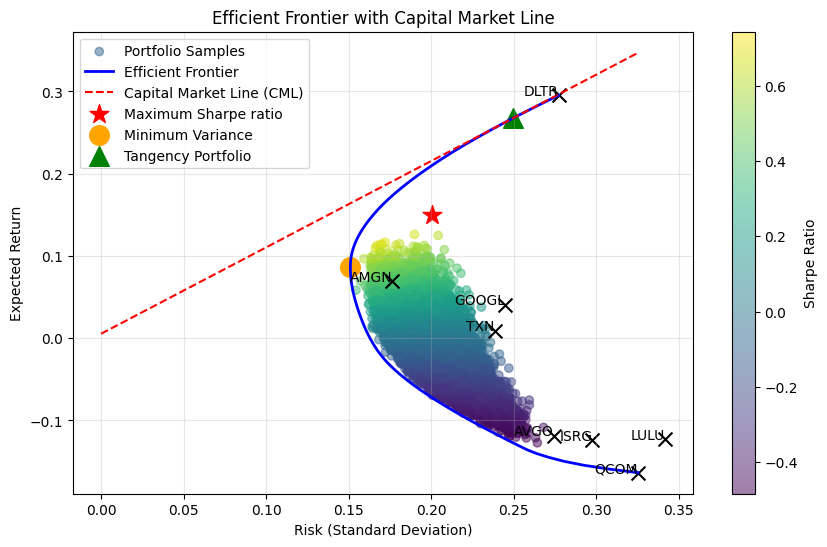


Tangency Portfolio Details:
Return: 0.2675
Risk: 0.2497

Tangency Portfolio Weights:
Asset 1: 0.0000
Asset 2: 0.1299
Asset 3: 0.0000
Asset 4: 0.8701
Asset 5: 0.0000
Asset 6: 0.0000
Asset 7: 0.0000
Asset 8: 0.0000


In [132]:

# Create the plot
plt.figure(figsize=(10, 6))
# Plot random portfolios
scatter = plt.scatter(results[1, :], results[0, :], 
                     c=results[2, :], 
                     cmap='viridis', 
                     alpha=0.5, 
                     label='Portfolio Samples')
# Plot efficient frontier
plt.plot(frontier_risks, frontier_returns, 
         color='blue', 
         linewidth=2, 
         label='Efficient Frontier')
# Plot CML
plt.plot(x_cml, y_cml, 
         color='red', 
         linestyle='--', 
         label='Capital Market Line (CML)')
# Plot maximum Sharpe ratio point
plt.scatter(max_sharpe_stddev, max_sharpe_return, 
           color='red', 
           marker='*', 
           s=200, 
           label='Maximum Sharpe ratio')
# Plot minimum variance point
plt.scatter(min_var_risk, min_var_return, 
           color='orange', 
           marker='o', 
           s=200, 
           label='Minimum Variance')
# Plot tangency portfolio
plt.scatter(tangency_risk, tangency_return, 
           color='green', 
           marker='^', 
           s=200, 
           label='Tangency Portfolio')
# Plot individual assets (stocks) with tickers
for i, ticker in enumerate(stock_files.keys()):
    plt.scatter(np.sqrt(covariance_matrix.iloc[i, i]) * np.sqrt(timeAnnual),  
                expected_returns[i] * timeAnnual,  
                color='black', 
                marker='x', 
                s=100)
    plt.annotate(ticker, 
                 (np.sqrt(covariance_matrix.iloc[i, i]) * np.sqrt(timeAnnual),  
                  expected_returns[i] * timeAnnual), 
                 fontsize=10, 
                 ha='right', 
                 color='black')

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Print tangency portfolio details
print("\nTangency Portfolio Details:")
print(f"Return: {tangency_return:.4f}")
print(f"Risk: {tangency_risk:.4f}")
print("\nTangency Portfolio Weights:")
for i, weight in enumerate(tangency_weights):
    print(f"Asset {i+1}: {weight:.4f}")

## 2.3. Security Market Line


The Security Market Line (SML) depicts the theoretical relationship between systematic risk (beta) and expected return of individual securities in equilibrium, as postulated by the Capital Asset Pricing Model (CAPM). In our graph, the SML is represented by the blue line, which starts at the risk-free rate and slopes upward, illustrating the positive linear relationship between beta and expected return.
The individual stocks in our portfolio, marked by red dots, are plotted according to their respective betas (x-axis) and expected returns (y-axis). The positioning of these stocks relative to the SML provides valuable insights:

Stock 2 appears to be positioned above the SML, suggesting it may be undervalued according to CAPM, offering higher returns than theoretically expected for its level of systematic risk.
Most stocks (stocks 3-8) lie below the SML, indicating they may be overvalued or offering lower returns than what CAPM would predict given their systematic risk.
The betas of our stocks range from approximately 0.2 to 1.0, with Stock 1 having the highest systematic risk (β ≈ 1.0) and Stock 2 having the lowest (β ≈ 0.2).
Several stocks show negative expected returns despite having positive betas, which could indicate poor historical performance or negative market sentiment during our analysis period.

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_2116\2522345132.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(tickers[i], (beta[i], expected_returns[i]))


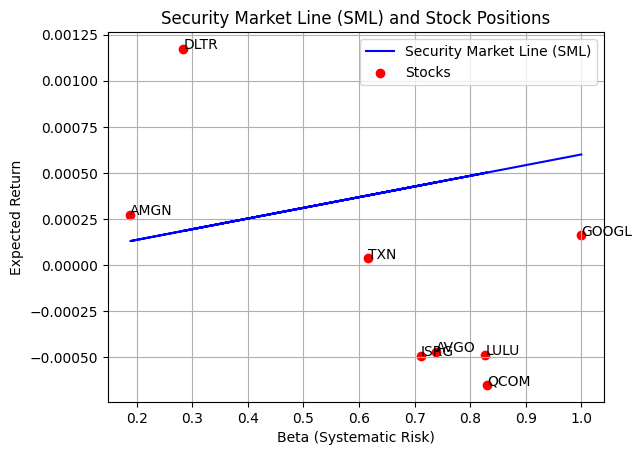

In [122]:
# Assume 'market_return' is the market's return (you can use a relevant benchmark like the S&P 500)
beta = covariance_matrix.iloc[:, 0] / covariance_matrix.iloc[0, 0]  # Simplified calculation using first stock as market proxy
expected_market_return = 0.0006  # Assumed daily expected market return (about 15% annually) ???
sml = risk_free_rate_one + beta * (expected_market_return - risk_free_rate_one)  # SML formula

# Extract the list of tickers from your dictionary
tickers = list(stock_files.keys())

# Plot the SML
plt.plot(beta, sml, label="Security Market Line (SML)", color='blue')

# Plot individual stocks based on their expected returns and betas
plt.scatter(beta, expected_returns, color='red', label="Stocks")
for i, txt in enumerate(expected_returns):
    plt.annotate(tickers[i], (beta[i], expected_returns[i]))

# Labels and title
plt.title("Security Market Line (SML) and Stock Positions")
plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


# The Markowitz Model

We have choosen strategy of min risk, min expected returns = 6 % p.a, the historical/empirical data was used.

#TODO: Try different estimation methods

In [133]:
def calculate_efficient_portfolio_with_rf(combined_returns, min_return, risk_free_rate):
    # Calculate excess returns and covariance matrix
    excess_returns = combined_returns.mean() - risk_free_rate
    covariance_matrix = combined_returns.cov()
    num_risky_assets = len(excess_returns)
    
    def objective(risky_weights):
        return 0.5 * np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights))*timeAnnual
    
    def return_constraint(risky_weights):
        portfolio_excess_return = np.dot(risky_weights, excess_returns)
        return portfolio_excess_return + risk_free_rate - min_return
    
    
    constraints = [
        {'type': 'ineq', 'fun': return_constraint}
    ]
    
    initial_weights = np.zeros(num_risky_assets) / (num_risky_assets)
    bounds = [(0, 1) for _ in range(num_risky_assets)]
    
    result = minimize(objective, initial_weights,
                     constraints=constraints,
                     bounds=bounds,
                     method='SLSQP')
    
    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")
    
    risky_weights = result.x
    rf_weight = 1-np.sum(risky_weights)
    
    portfolio_risk = np.sqrt(np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights)))
    portfolio_return = np.dot(risky_weights, combined_returns.mean()) + rf_weight * risk_free_rate
    
    weight_dict = dict(zip(combined_returns.columns, risky_weights))
    weight_dict['risk_free'] = rf_weight
    
    return {
        'weights': weight_dict,
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk,
        'risk_free_weight': rf_weight
    }

In [135]:
risk_free_rate_all = risk_free_rate_cleaned['Daily_Risk_Free_Rate'].mean()

In [136]:
# Example usage:
# Replace `stock_data` with your data (a dictionary of DataFrames with 'Close' prices for each stock)
# Set a minimum daily return (e.g., 0.00023 for ~6% annual return)
min_return = 0.00023
portfolioMark = calculate_efficient_portfolio_with_rf(
    combined_returns_cleaned,
    min_return,
    risk_free_rate_all
)

print("Portfolio weights:", portfolioMark['weights'])
print("Expected return:", portfolioMark['portfolio_return'])
print("Portfolio risk:", portfolioMark['portfolio_risk'])
print("Risk-free asset weight:", portfolioMark['risk_free_weight'])
print(sum(portfolioMark['weights'].values()))

Portfolio weights: {'GOOGL': 0.23101114956265442, 'AMGN': 0.0, 'AVGO': 0.0, 'DLTR': 6.722053469410129e-18, 'ISRG': 6.071532165918827e-18, 'LULU': 0.0, 'QCOM': 0.0, 'TXN': 4.336808689942018e-18, 'risk_free': 0.7689888504373456}
Expected return: 0.00022999999993116716
Portfolio risk: 0.0034157191849773024
Risk-free asset weight: 0.7689888504373456
1.0


C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_2116\3756539421.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns[i]*timeAnnual,


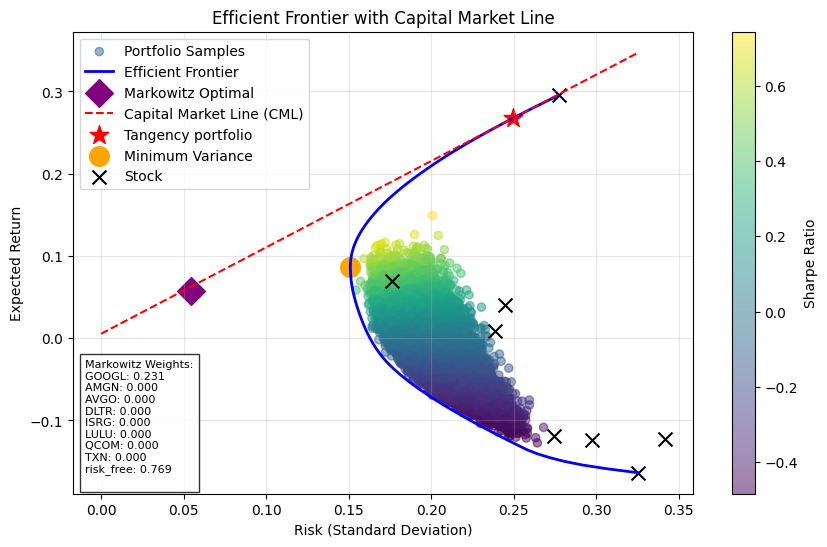

In [137]:
# Your existing plot code with Markowitz additions
plt.figure(figsize=(10, 6))

# Plot random portfolios (your existing code)
scatter = plt.scatter(results[1, :], results[0, :], 
                     c=results[2, :], 
                     cmap='viridis', 
                     alpha=0.5, 
                     label='Portfolio Samples')

# Plot efficient frontier (your existing code)
plt.plot(frontier_risks, frontier_returns, 
        color='blue', 
        linewidth=2, 
        label='Efficient Frontier')

# Get Markowitz results and add to plot
markowitz_risk = portfolioMark['portfolio_risk'] * np.sqrt(timeAnnual)
markowitz_return = portfolioMark['portfolio_return'] * timeAnnual

# Plot Markowitz optimal portfolio
plt.scatter(markowitz_risk, markowitz_return,
           color='purple',
           marker='D',
           s=200,
           label='Markowitz Optimal')

# Plot CML using Markowitz portfolio (your existing code, updated)
plt.plot(x_cml, y_cml, 
         color='red', 
         linestyle='--', 
         label='Capital Market Line (CML)')

# Your existing code continues...
# Plot tangency portfolio
plt.scatter(tangency_risk, tangency_return, 
          color='red', 
          marker='*', 
          s=200, 
          label='Tangency portfolio')

# Plot minimum variance point
plt.scatter(min_var_risk, min_var_return, 
          color='orange', 
          marker='o', 
          s=200, 
          label='Minimum Variance')

# Plot individual assets (stocks)
for i in range(len(expected_returns)):
    plt.scatter(np.sqrt(covariance_matrix.iloc[i, i])* np.sqrt(timeAnnual),
                expected_returns[i]*timeAnnual,
                color='black', 
                marker='x', 
                s=100, 
                label=f'Stock' if i == 0 else "")

# Add Markowitz weights as text
weights_text = "Markowitz Weights:\n"
for asset, weight in portfolioMark['weights'].items():
    weights_text += f"{asset}: {weight:.3f}\n"
plt.text(0.02, 0.02, weights_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=8)

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

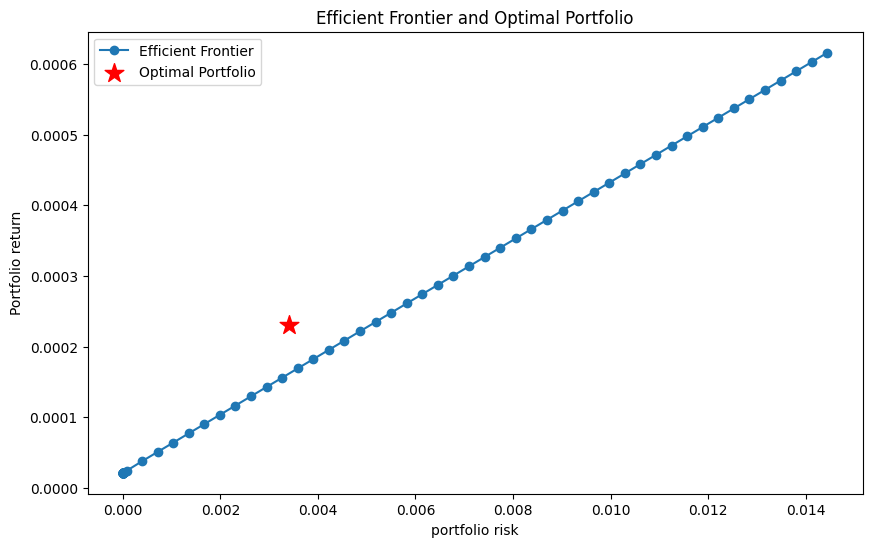

In [139]:
# Not working
market_return = portfolioMark['portfolio_return']
market_risk = portfolioMark['portfolio_risk']
num_portfolios = 100
results = np.zeros((3, num_portfolios))
# Get max and min expected returns to ensure feasible minimum return
min_expected_return = combined_returns.mean().min()
max_expected_return = combined_returns.mean().max()
for i in range(num_portfolios):
    # Vary the expected return for each portfolio
    min_return = min_expected_return + (i / num_portfolios) * (max_expected_return - min_expected_return)
    
    try:
        portfolio = calculate_efficient_portfolio_with_rf(combined_returns, min_return, risk_free_rate_one)
        results[0, i] = portfolio['portfolio_risk']
        results[1, i] = portfolio['portfolio_return']
    except ValueError as e:
        # Handle cases where optimization fails
        print(f"Optimization failed for target return {min_return:.4f}. Skipping.")
        results[0, i] = np.nan
        results[1, i] = np.nan


# Plot CML (opacko from above, still not working)
# ??? How to choose market risk and market returns
cml_x = np.linspace(0, market_risk * 1.5, 100)
cml_y = risk_free_rate_one + (cml_x / market_risk) * (market_return - risk_free_rate_one)
# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(results[0, :], results[1, :], marker='o', label='Efficient Frontier')
#plt.plot(cml_x, cml_y, color='green', label='Capital Market Line (CML)') (same naprd results)
plt.scatter(portfolioMark['portfolio_risk'], portfolioMark['portfolio_return'], color='red', marker='*', s=200, label='Optimal Portfolio')
plt.title('Efficient Frontier and Optimal Portfolio')
plt.xlabel('portfolio risk')
plt.ylabel('Portfolio return')
plt.legend(loc='best')
plt.show()

# Out-Of-Sample Investing

In [126]:
start_date2 = '2022-10-25'
end_date2 = '2024-10-24'
initial_investment = 100000

# Filter the data by date range using the index
combined_returns_subset2 = combined_returns_cleaned[(combined_returns_cleaned.index >= start_date2) & 
                                  (combined_returns_cleaned.index <= end_date2)]
risk_free_subset2 = risk_free_rate_cleaned[(risk_free_rate_cleaned.index >= start_date2) & 
                                  (risk_free_rate_cleaned.index <= end_date2)]

In [127]:
#print(combined_returns_subset2.head(), combined_returns_subset2.tail())

               GOOGL      AMGN      AVGO      DLTR      ISRG      LULU  \
Date                                                                     
2022-10-25  0.015238 -0.001921  0.004531  0.029007  0.029177  0.060358   
2022-10-26 -0.015678  0.013858  0.006941 -0.007390  0.016312  0.014261   
2022-10-27 -0.024634 -0.002877 -0.023117  0.013729 -0.003098 -0.008974   
2022-10-28  0.042645  0.015198  0.034288  0.016791  0.013276  0.044637   
2022-10-31 -0.009583  0.004263  0.006980  0.004680  0.014179  0.012354   

                QCOM       TXN  
Date                            
2022-10-25  0.022059  0.003397  
2022-10-26  0.000593  0.034148  
2022-10-27 -0.039489 -0.019207  
2022-10-28  0.043198  0.034551  
2022-10-31 -0.003987  0.001433                  GOOGL      AMGN      AVGO      DLTR      ISRG      LULU  \
Date                                                                     
2024-10-18  0.001408  0.003270 -0.013418  0.004261  0.049462  0.028097   
2024-10-21  0.006850 -0.0107

In [129]:
def backtest_portfolio_strategy(returns_data, start_date, end_date, initial_investment=100000, 
                              lookback_window=252, risk_free_rate=0.02/252):
    """
    Backtest portfolio strategy with daily rebalancing
    """
    # Initialize results storage
    portfolio_values = []
    portfolio_weights = []
    dates = []
    
    # Initialize portfolio tracking
    current_value = initial_investment
    
    # Get list of trading dates
    trading_dates = returns_data.loc[start_date:end_date].index
    
    # Initialize benchmark portfolios
    equal_weight_value = initial_investment
    equal_weights = pd.Series(1/len(returns_data.columns), index=returns_data.columns)
    
    # Calculate initial tangency portfolio (fixed)
    # Fix: Use proper indexing for lookback
    full_index = returns_data.index
    start_idx = full_index.get_loc(start_date)
    lookback_start_idx = max(0, start_idx - lookback_window)
    initial_lookback = returns_data.iloc[lookback_start_idx:start_idx]
    fixed_tangency_weights = calculate_tangency_portfolio(initial_lookback, risk_free_rate)
    fixed_tangency_value = initial_investment
    
    # Track all strategy values
    strategy_values = {'Optimal': [initial_investment],
                      'Equal-Weight': [initial_investment],
                      'Fixed-Tangency': [initial_investment]}
    
    # Loop through each trading day
    for i in range(len(trading_dates)-1):
        current_date = trading_dates[i]
        next_date = trading_dates[i+1]
        
        # Fix: Use proper indexing for historical data
        current_idx = full_index.get_loc(current_date)
        lookback_start_idx = max(0, current_idx - lookback_window)
        historical_data = returns_data.iloc[lookback_start_idx:current_idx]
        
        # Calculate optimal weights for next day
        try:
            optimal_weights = calculate_tangency_portfolio(historical_data, risk_free_rate)
        except:
            # If optimization fails, use previous weights
            optimal_weights = portfolio_weights[-1] if portfolio_weights else equal_weights
        
        # Get next day's returns
        next_day_returns = returns_data.loc[next_date]
        
        # Update portfolio values
        # Optimal strategy
        current_value *= (1 + np.sum(optimal_weights * next_day_returns))
        strategy_values['Optimal'].append(current_value)
        
        # Equal weight benchmark
        equal_weight_value *= (1 + np.sum(equal_weights * next_day_returns))
        strategy_values['Equal-Weight'].append(equal_weight_value)
        
        # Fixed tangency benchmark
        fixed_tangency_value *= (1 + np.sum(fixed_tangency_weights * next_day_returns))
        strategy_values['Fixed-Tangency'].append(fixed_tangency_value)
        
        # Store results
        portfolio_values.append(current_value)
        portfolio_weights.append(optimal_weights)
        dates.append(next_date)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(strategy_values, index=trading_dates)
    weights_df = pd.DataFrame(portfolio_weights, index=dates, columns=returns_data.columns)
    
    return results_df, weights_df

def calculate_tangency_portfolio(returns_data, risk_free_rate):
    """
    Calculate the tangency portfolio weights
    """
    mean_returns = returns_data.mean()
    cov_matrix = returns_data.cov()
    
    def objective(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
        return -sharpe_ratio  # Minimize negative Sharpe ratio
    
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # weights sum to 1
    bounds = [(0, 1) for _ in range(len(returns_data.columns))]
    
    result = minimize(objective, 
                     np.ones(len(returns_data.columns)) / len(returns_data.columns),
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)
    
    return pd.Series(result.x, index=returns_data.columns)

def plot_backtest_results(results_df):
    """
    Plot the performance of all strategies
    """
    plt.figure(figsize=(12, 6))
    for strategy in results_df.columns:
        plt.plot(results_df.index, results_df[strategy], label=strategy)
    
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display performance metrics
    performance_metrics = {}
    for strategy in results_df.columns:
        returns = results_df[strategy].pct_change().dropna()
        performance_metrics[strategy] = {
            'Total Return': (results_df[strategy].iloc[-1] / results_df[strategy].iloc[0] - 1) * 100,
            'Annual Return': (returns.mean() * 252) * 100,
            'Annual Volatility': (returns.std() * np.sqrt(252)) * 100,
            'Sharpe Ratio': (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)
        }
    
    return pd.DataFrame(performance_metrics).round(2)

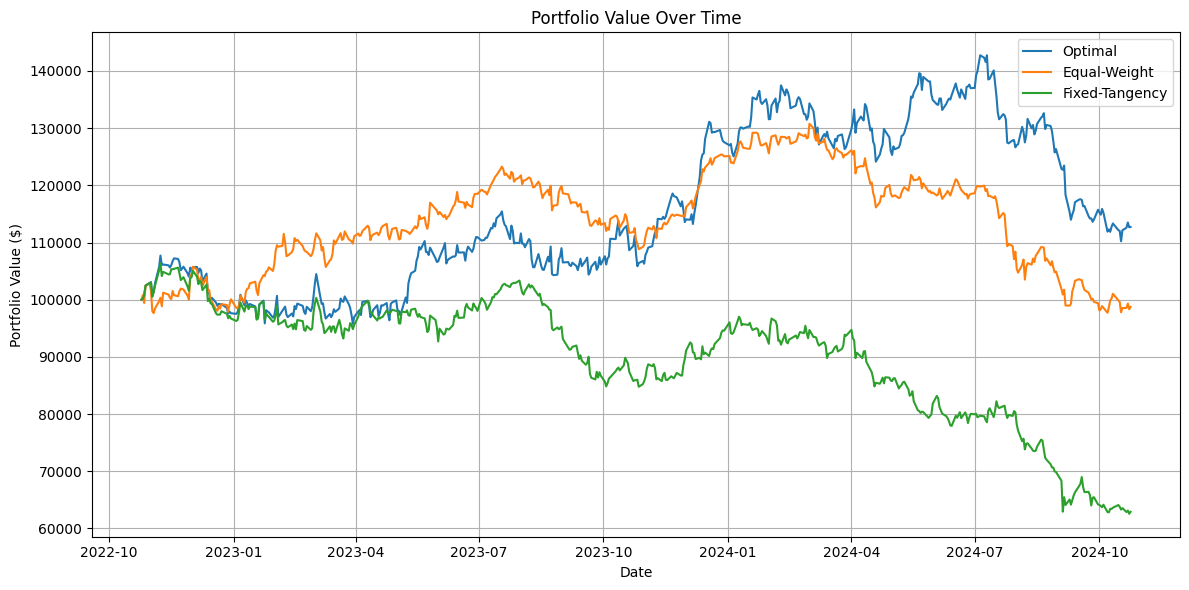


Performance Metrics:
                                                             Optimal  \
Total Return                                               12.715782   
Annual Return                                               8.080429   
Annual Volatility                                          20.165941   
Sharpe Ratio                          1 Mo  Daily_Risk_Free_Rate
...   

                                                        Equal-Weight  \
Total Return                                               -1.257588   
Annual Return                                               0.553075   
Annual Volatility                                          15.444977   
Sharpe Ratio                          1 Mo  Daily_Risk_Free_Rate
...   

                                                      Fixed-Tangency  
Total Return                                              -37.099705  
Annual Return                                             -21.604898  
Annual Volatility                          

In [130]:
rf2 = risk_free_subset2.mean()

results_df, weights_df = backtest_portfolio_strategy(
    combined_returns_cleaned,
    start_date2,
    end_date2,
    initial_investment=initial_investment
)

# Plot results and get performance metrics
metrics = plot_backtest_results(results_df)
print("\nPerformance Metrics:")
print(metrics)

# Print final portfolio values
print("\nFinal Portfolio Values:")
for strategy in results_df.columns:
    final_value = results_df[strategy].iloc[-1]
    profit_loss = final_value - initial_investment
    print(f"{strategy}: ${final_value:,.2f} (P/L: ${profit_loss:,.2f})")